<center>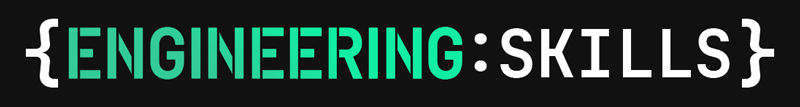</center> 

<center ><a href="https://www.engineeringSkills.com/" style="color: #3FFCD9; font-size:20px">www.EngineeringSkills.com</a></center>


## Parametric Continuous Beam Calculator using OpenSeesPy and Opsvis (with hinges)

[Tutorial Article on EngineeringSkills.com](https://www.engineeringskills.com/posts/parametric-continuous-beam-calculator-with-openseespy)

## 0.0 Dependencies

In [ ]:
import openseespy.opensees as ops 
import opsvis as opsv 
import numpy as np
import matplotlib.pyplot as plt

debugMode = True

In [ ]:
if debugMode:
	from importlib.metadata import version, packages_distributions

	def show_pkg_version(module_name):		
		# Map between installed package names and their distribution
		dist_map = packages_distributions() 			

		# Distribution that provides package with module_name
		dist = dist_map.get(module_name, [])[0] 
		
		print(f"{module_name}: {dist} {version(dist)}")
	
	print("Versions:")
	show_pkg_version("openseespy")
	show_pkg_version("opsvis")
	show_pkg_version("numpy")
	show_pkg_version("matplotlib")


## 1.0 Constants and Structure Definition

In [ ]:
#Constants
E = 200*10**9 	#[N/m^2] Young's Modulus
A = 0.03 				#[m^2] Cross-sectional area
Iz = 300*10**-6 #[m^4] Second moment of area

#Parameters 
L = 10 #(m) Total beam length

#Restraints [pos, Ux_Restraint, Uy_Restraint ThetaZ_Restraint]
r = np.array([			
	[1, 1, 1, 0], #Pin    
	[4, 0, 1, 0], #Roller
	[7, 0, 1, 0], #Roller
	[9, 0, 1, 0], #Roller
])

#Point Forces and Moments [pos, Fx, Fy, Mz]
p = np.array([
	[3, 0., -30000., 0.],
	[5, 0., -10000., 0.],
	[5, 0., 0., 5000.]
])

#Distributed Forces [pos_start, pos_end, intensity_start, intensity_end]
w = np.array([
	[0, 10, -20000, -20000], #UDL
	[0, 10, 0, -5000] #Linear Load
])

#Add nodes at specific query locations (e.g. for moment, shear and displacement reporting)
q = np.array([0.5, 2, 6.25])

# Rotational hinge location
h = np.array([7.5])

## 2.0 OpenSeesPy Model 

In [ ]:
ops.wipe() 
ops.model('basic', '-ndm', 2, '-ndf', 3) 

### 2.1 Define nodes

In [ ]:
# Initialse the array with entries for start and end of beam
nodeLocations = np.array([0, L]) 

# Add nodes at each restraint location
nodeLocations = np.append(nodeLocations, r[:, 0])

# Add nodes at each point action location
if len(p)>0: nodeLocations = np.append(nodeLocations, p[:, 0])

# Add node at start and end of each distributed load
if len(w)>0: nodeLocations = np.append(nodeLocations, np.concatenate((w[:, 0], w[:, 1])))

# Add node at each query location
if len(q)>0: nodeLocations = np.append(nodeLocations, q)

# Add node at each rotational hinge location
if len(h)>0: nodeLocations = np.append(nodeLocations, h)

# De-duplicate and sort
nodeLocations = np.unique(nodeLocations)
nodeLocations.sort()
print(nodeLocations)

### 2.2 Generate left and right maps for location to node tags

In [ ]:
# Hinge set for fast membership tests
hingeLocations = set(float(x) for x in h) if len(h) > 0 else set()

# Maps from location -> node tag(s)
# For non-hinge locations: leftTag == rightTag
loc2tagL = {}
loc2tagR = {}

# Create nodes (duplicate at hinges)
nodeTag = 0
for i, n in enumerate(nodeLocations):
	xCoord = float(n)

	if xCoord in hingeLocations:
		# Left node at hinge
		nodeTag += 1
		tagL = int(nodeTag)
		ops.node(tagL, xCoord, 0.0)
		if debugMode: print(f'Node {tagL} (hinge-L) defined')

		# Right node at hinge (coincident)
		nodeTag += 1
		tagR = int(nodeTag)
		ops.node(tagR, xCoord, 0.0)
		if debugMode: print(f'Node {tagR} (hinge-R) defined')

		loc2tagL[xCoord] = tagL
		loc2tagR[xCoord] = tagR
	else:
		nodeTag += 1
		tag = int(nodeTag)
		ops.node(tag, xCoord, 0.0)
		if debugMode: print(f'Node {tag} defined')

		loc2tagL[xCoord] = tag
		loc2tagR[xCoord] = tag

print(loc2tagL)
print(loc2tagR)

### 2.3 Apply hinge constraints

In [ ]:
# Apply hinge constraints: tie translations only (Ux=1, Uy=2), release rotation (Rz=3)
for xCoord in hingeLocations:
	ops.equalDOF(loc2tagL[xCoord], loc2tagR[xCoord], 1, 2)
	if debugMode: print(f'Hinge added at x={xCoord} between nodes {loc2tagL[xCoord]} and {loc2tagR[xCoord]}')


### 2.4 Define beam elements

In [ ]:
# Define a linear transformation between member local RF and global RF
transfType = 'Linear'
transfTag = 1
ops.geomTransf(transfType, transfTag)

In [ ]:
# Define beam elements
for n in range(len(nodeLocations)-1):
	startPos = nodeLocations[n]
	endPos   = nodeLocations[n+1]

	# Key rule:
	# - element starts on the "right" tag of the start position
	# - element ends on the "left" tag of the end position
	startNode = loc2tagR[startPos]
	endNode   = loc2tagL[endPos]

	eleTag = n+1

	ops.element('elasticBeamColumn', eleTag, startNode, endNode, A, E, Iz, transfTag)
	if debugMode: print(f'Beam with tag {eleTag} defined between nodes {startNode} and {endNode}')

### 2.5 Definition restraints

In [ ]:
for i, R in enumerate(r):        
	location = R[0] #Restraint location
	nodeTag = loc2tagL[location]  # use left tag by default

	nodeFixity = (nodeTag, *(int(x) for x in R[1:]))	
	ops.fix(*nodeFixity) #Define restraint using fixity specified
	if debugMode: print(f'Restraint added to node {nodeTag} with fixity {nodeFixity[1::]}')

### 2.6 Nodal Actions (Forces and Moments)

In [ ]:
# Create TimeSeries with a tag of 1
ops.timeSeries("Constant", 1)

# Create a plain load pattern associated with the TimeSeries (pattern, patternTag, timeseriesTag)
ops.pattern("Plain", 1, 1)

In [ ]:
for P in p:
	location = P[0] #Action location	
	nodeTag = int(loc2tagL[location])  #apply to left tag by default
	
	loadDefinition = (nodeTag, *P[1::])
	ops.load(*loadDefinition)                    
	if debugMode: print(f'Point action applied to node {nodeTag}: {P[1::]}')

### 2.7 Uniformly distributed loads

In [ ]:
for W in w: 
	# Only process uniformly distributed loads in this block
	if W[2] == W[3]:
		startLocation = W[0]
		endLocation   = W[1]
		if debugMode: print(f'Load extents: {startLocation} to {endLocation}')

		# Find location indices in nodeLocations 
		startIndexLoad = np.where(nodeLocations == startLocation)[0].item()
		endIndexLoad = np.where(nodeLocations == endLocation)[0].item()
		if debugMode: print(f'Load extents: position index {startIndexLoad} to position index {endIndexLoad}')

		# Apply load to each element fully within the extents
		# Element with tag (n+1) spans nodeLocations[n] -> nodeLocations[n+1]
		for n in range(startIndexLoad, endIndexLoad):
			eleTag = int(n+1)
			ops.eleLoad('-ele', eleTag, '-type', '-beamUniform', float(W[2]))
			if debugMode: print(f'Applied load of {W[2]} to member {eleTag}')


### 2.8 Linearly varying loads

In [ ]:
for W in w: 
	# Only process non-uniformly distributed loads in this block
	if W[2] != W[3]:			
		startLocation = W[0]
		endLocation   = W[1]
		if debugMode: print(f'Load extents: {startLocation} to {endLocation}')
		
		slope = (W[3]-W[2])/(W[1]-W[0])
		
		# Find location indices in nodeLocations (position-based, not nodeTag-based)
		startIndexLoad = np.where(nodeLocations == startLocation)[0].item()
		endIndexLoad   = np.where(nodeLocations == endLocation)[0].item()
		if debugMode: print(f'Load extents: index {startIndexLoad} to index {endIndexLoad}')
		
		# Apply load to each element fully within the extents
		# Element with tag (n+1) spans nodeLocations[n] -> nodeLocations[n+1]
		for n in range(startIndexLoad, endIndexLoad):
			eleTag = int(n+1)
			
			# What is the position of start and end for this beam element
			startPosition = nodeLocations[n]
			endPosition   = nodeLocations[n+1]
			
			# Determine load magnitude at start of beam element
			startMag = W[2] + (slope * (startPosition - startLocation))
			
			# Determine load magnitude at end of beam element
			endMag   = W[2] + (slope * (endPosition - startLocation))
			
			# Apply linearly varying load to beam element
			"""
			Ref: https://portwooddigital.com/2021/05/05/trapezoidal-beam-loads/
			eleLoad('-ele', eleTag,'-type','beamUniform', wya,wxa,aOverL,bOverL,wyb,wxb)
			"""
			ops.eleLoad('-ele', eleTag, '-type', 'beamUniform', float(startMag), 0, 0, 1, float(endMag), 0)
			if debugMode: print(f'Applied load varying from {startMag} to {endMag} to member {eleTag}')


### 2.9 Analysis

In [ ]:
# Create SOE - BandGeneral is a general solver suitable for most linear problems
ops.system('BandGeneral')  

# Reverse Cuthill–McKee - reorders DOFs to improve efficiency and numerical performance
ops.numberer('RCM')

# Create constraint handler
ops.constraints('Transformation')

# Create integrator - the entire load is applied in a single step
ops.integrator('LoadControl', 1)

# Create algorithm - assume linear structural behaviour
ops.algorithm('Linear')

# Create analysis object - no time-dependency
ops.analysis('Static')

# Perform the analysis (with 1 analysis step)
ops.analyze(1)

## 3.0 Results - Reactions

In [ ]:
ops.reactions() #Calculate reactions

print("REACTIONS")
print('----------')

for i, R in enumerate(r):        
	location = R[0] #Restraint location        
	nodeTag = loc2tagL[location] # Left node by default (node that any restraint at this location was applied to)
	
	dofR = ops.nodeReaction(nodeTag) #Reactions for this node
	Rx = round(dofR[0]/1000,2)
	Ry = round(dofR[1]/1000,2)
	Mz = round(dofR[2]/1e6,2)
	print(f'Reactions at node {nodeTag}: Rx = {Rx} kN, Ry = {Ry} kN, Mz = {Mz} kNm')

## 4.0 Results: Nodal displacements/rotations

In [ ]:
print('DISPLACEMENTS/ROTATIONS')
print("------------------------")
for i, x in enumerate(nodeLocations):
	tagL = loc2tagL[x]
	tagR = loc2tagR[x]
	
	# Always report left node
	delta = ops.nodeDisp(tagL)
	Ux = round(delta[0]/1000,10)
	Uy = round(delta[1]/1000,10)
	thetaZ = round(delta[2],6)
	
	print(f'Node {tagL} at {x} m: Ux = {Ux} m, Uy = {Uy} m, thetaZ = {thetaZ} rads')

	# If hinge (different tag), also report right node (rotations differ)
	if tagR != tagL:
		delta = ops.nodeDisp(tagR)
		Ux = round(delta[0]/1000, 10)
		Uy = round(delta[1]/1000, 10)
		thetaZ = round(delta[2], 6)
		print(f'Node {tagR} at {x} m: Ux = {Ux} m, Uy = {Uy} m, thetaZ = {thetaZ} rads')
    

## 5.0 Opsvis plotting functions

### 5.1 Plot structure

In [ ]:
# Print model to confirm visually
def plotStructure():
	opsv.plot_model(fig_wi_he=(50,20)) 
	plt.title('Beam')
	plt.xlabel('Distance (m)')	
	plt.xticks(np.arange(0,L+1,1))
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

### 5.2 Plot loads

In [ ]:
def plotLoads():
	opsv.plot_load(fig_wi_he=(50,20))            
	plt.title('Beam and Loading')	
	plt.xlabel('Distance (m)')	
	plt.xticks(np.arange(0,L+1,1))	
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

### 5.3 Plot reactions

In [ ]:
def plotReactions():
	opsv.plot_reactions(fig_wi_he=(50,20))
	plt.title('Reactions')
	plt.xlabel('Distance (m)')	
	plt.xticks(np.arange(0,L+1,1))
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

### 5.4 Plot deflection

In [ ]:
def plotDEF():
	s = opsv.plot_defo(        
		fig_wi_he=(50,20), 
		fmt_defo={'color': 'red', 'linestyle': (0, (4, 5)), 'linewidth': 1.5},
		fmt_undefo={'color': 'green', 'linestyle': 'solid', 'linewidth': 2,},
	)
	plt.title('Deflection')
	plt.xlabel('Distance (m)')
	plt.xticks(np.arange(0,L+1,1))
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

### 5.5 Plot bending moment diagram

In [ ]:
def plotBMD(sFac):
	opsv.section_force_diagram_2d(
		'M', sFac, fig_wi_he=(50,20),
		fmt_secforce1={'color': 'green'},
		fmt_secforce2={'color': 'green'}
	)
	plt.title('Bending Moment Diagram')
	plt.xlabel('Distance (m)')	
	plt.xticks(np.arange(0,L+1,1))
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

### 5.6 Plot shear force diagram

In [ ]:
def plotSFD(sFac):
	opsv.section_force_diagram_2d(
		'V', sFac, fig_wi_he=(50,20),
		fmt_secforce1={'color': 'red'},
		fmt_secforce2={'color': 'red'}
	)
	plt.title('Shear Force Diagram')
	plt.xlabel('Distance (m)')	
	plt.xticks(np.arange(0,L+1,1))
	ax = plt.gca()
	ax.tick_params(axis='y', labelleft=False)
	plt.grid()
	plt.show()

## 6.0 Summary Plots

In [ ]:
plotStructure()
plotLoads() 
plotReactions()
plotSFD(3.e-5)
plotBMD(5.e-5)
plotDEF()